In [149]:
#data handling
import pandas as pd
import numpy as np
import pprint

#plotting
import matplotlib.pyplot as plt

#model building
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs



In [150]:
# Load dataset
# Boardgames and rankings
boardgames_df = pd.read_csv('data/boardgames_ranks.csv')
# Boardgame details like, rating, playtime etc.
boardgames_details_df = pd.read_csv('data/game_details.csv')


# Rename columns
boardgames_df.rename(columns={'id' : 'game_id', 'name': 'game_name'}, inplace=True)
# Merge both datasets 
df_merged = boardgames_df.merge(boardgames_details_df, on='game_id', how='left')
# Only keep boardgames that are ranked
df_merged = df_merged[df_merged['rank'] >= 1]


In [151]:
# List of features for model building
feature_names = ['rank', 'average', 'usersrated', 'playingtime','averageweight']

# Create feature dataset
df_features = df_merged[feature_names]

# Create game id dataset (important for indexing later)
df_game_ids = df_merged['game_id']

In [152]:
# # Create candidate dictionary with featurer and game_id keys 
# candidate_data = []
# for index, feature_row in df_features.iterrows():
#     # Convert the row to a list of feature values.
#     features_list = feature_row.tolist()  
#     # Retrieve the corresponding game_id from df_game_ids using the same index
#     game_id = df_game_ids.iloc[index] 

#     # Append the dictionary with keys 'features' and 'game_id'
#     candidate_data.append({"features": features_list, "game_id": game_id})



In [153]:
# Create candidate dictionary with features and game_id keys 
candidate_data_dict = {
    "features": [],
    "game_id": []
}

for index, feature_row in df_features.iterrows():
    candidate_data_dict["features"].append(feature_row.tolist())  
    candidate_data_dict["game_id"].append(df_game_ids.iloc[index])


In [154]:
# # Convert the list of dicts into a dict of lists.
# candidate_data_dict = {
#     "features": [item["features"] for item in candidate_data],
#     "game_id": [item["game_id"] for item in candidate_data]
# }

In [155]:
# Convert the list into a tensorflow dataset
candidate_dataset = tf.data.Dataset.from_tensor_slices(candidate_data_dict)

# Batch data for optimization
candidate_dataset = candidate_dataset.batch(32)

In [156]:
# Split feature dataset into train, validation, and test sets
train_data, test_data = train_test_split(df_features, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [157]:
# Create a tensorflow normalization layer and adapt it on the training data
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(train_data.to_numpy())

In [158]:
# Function for creating train, validation and test tensorflow datasets
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices({"features": dataframe.to_numpy()})
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 32
train_ds = df_to_dataset(train_data, batch_size=batch_size)
val_ds = df_to_dataset(val_data, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_data, shuffle=False, batch_size=batch_size)

In [159]:
# for x in all_boardgames_ds.take(1).as_numpy_iterator():
#   pprint.pprint(x)

In [160]:
# # Create the boardgame dataset
# all_boardgames_ds = tf.data.Dataset.from_tensor_slices({
#     "features": df_features.to_numpy().astype('float32'),
#     "game_id": df_game_ids.to_numpy().astype('int32')
# })
# all_boardgames_ds = all_boardgames_ds.batch(32)

# # Create the candidate dataset, then unbatch it and batch it again to ensure correct shape
# candidate_ds = all_boardgames_ds.map(lambda x: x["features"]).unbatch().batch(32)


In [161]:
# Define the BoardgameContentModel class
class BoardgameContentModel(tfrs.Model):
    # Initialize the parent tfrs.Model class.
    def __init__(self, embedding_dim, candidate_dataset):
        super().__init__()
        
        # Build the boardgame feature encoder (tower)
        # - Input: Feature vector with length equal to number of feature_names
        # - Hidden layer: 64 neurons with ReLU activation
        # - Output layer: Projects to the embedding space of dimension `embedding_dim`
        # - Normalization: L2 normalization for cosine similarity      
        self.boardgame_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(len(feature_names),)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(embedding_dim),
            tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        ])
        
        # Precompute candidate embeddings from the candidate dataset
        # Each candidate is expected to be a dictionary with a features key    
        candidate_embeddings = candidate_dataset.map(
            lambda x: self.boardgame_model(x["features"])
        )
        
        # Configure the retrieval task with FactorizedTopK metrics using the candidate embeddings
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(candidates=candidate_embeddings)
        )
        
    # The compute_loss method defines how the model's loss is computed during training
    def compute_loss(self, features, training=False):
        # Compute boardgame embeddings from the input features.
        boardgame_embeddings = self.boardgame_model(features["features"])
        
        # Use the embeddings as both query and candidate for the retrieval task
        # The task computes a loss based on ranking similar items higher    
        return self.task(boardgame_embeddings, boardgame_embeddings)




Epoch 1/2
629/629 [==============================] - 125s 198ms/step - factorized_top_k/top_1_categorical_accuracy: 1.0000 - factorized_top_k/top_5_categorical_accuracy: 1.0000 - factorized_top_k/top_10_categorical_accuracy: 1.0000 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 89.9374 - regularization_loss: 0.0000e+00 - total_loss: 89.9374 - val_factorized_top_k/top_1_categorical_accuracy: 0.6531 - val_factorized_top_k/top_5_categorical_accuracy: 0.9951 - val_factorized_top_k/top_10_categorical_accuracy: 0.9978 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 68.5241 - val_regularization_loss: 0.0000e+00 - val_total_loss: 68.5241
Epoch 2/2
629/629 [==============================] - 120s 191ms/step - factorized_top_k/top_1_categorical_accuracy: 1.0000 - factorized_top_k/top_5_categorical_accuracy: 1.0000 - factorized_top_k/top_10_cate

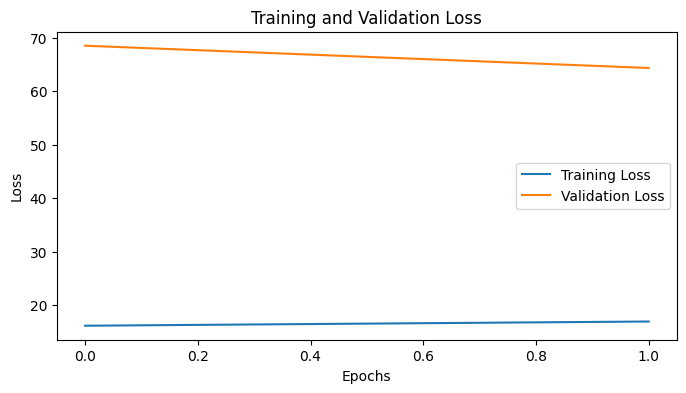

In [162]:
# Pass candidate_ds to your model
embedding_dim = 32
model = BoardgameContentModel(embedding_dim, candidate_dataset)

# Compile the model with the adam adaptive learning rate optimization algorithm
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=2)

# Plot the training and validation loss over epochs.
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

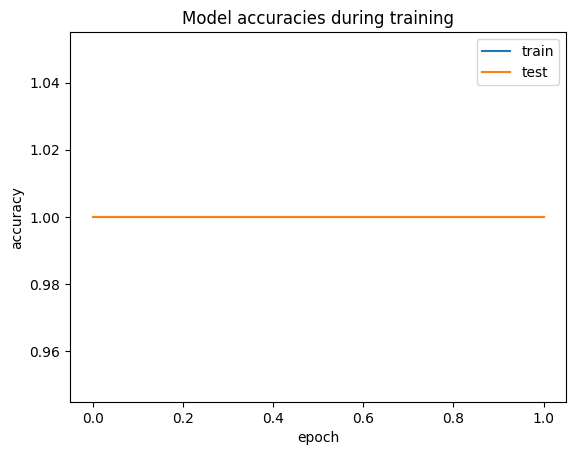

In [163]:
# Plot changes in model accuracy during training
plt.plot(history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [164]:
# Evaluate model on test data 
model.evaluate(test_ds, return_dict=True)

175/175 [==============================] - 30s 172ms/step - factorized_top_k/top_1_categorical_accuracy: 0.6772 - factorized_top_k/top_5_categorical_accuracy: 0.9962 - factorized_top_k/top_10_categorical_accuracy: 0.9982 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 85.5311 - regularization_loss: 0.0000e+00 - total_loss: 85.5311


{'factorized_top_k/top_1_categorical_accuracy': 0.677170991897583,
 'factorized_top_k/top_5_categorical_accuracy': 0.9962399005889893,
 'factorized_top_k/top_10_categorical_accuracy': 0.9982094764709473,
 'factorized_top_k/top_50_categorical_accuracy': 1.0,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 35.32411575317383,
 'regularization_loss': 0,
 'total_loss': 35.32411575317383}

In [165]:
# Custom callback to evaluate on the test set after each epoch.
class TestSetEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, test_dataset):
        super().__init__()
        self.test_dataset = test_dataset
        self.test_metrics = []  # To store metrics from each epoch

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate the model on the test set silently
        test_result = self.model.evaluate(self.test_dataset, verbose=0)
        # Create a dictionary mapping metric names to their values
        metrics_dict = dict(zip(self.model.metrics_names, test_result))
        self.test_metrics.append(metrics_dict)
        print(f"Test metrics after epoch {epoch+1}: {metrics_dict}")

# Assume you have a test dataset called `test_ds`
test_evaluator = TestSetEvaluator(test_ds)

# Train the model while using the custom callback
# history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[test_evaluator])


ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

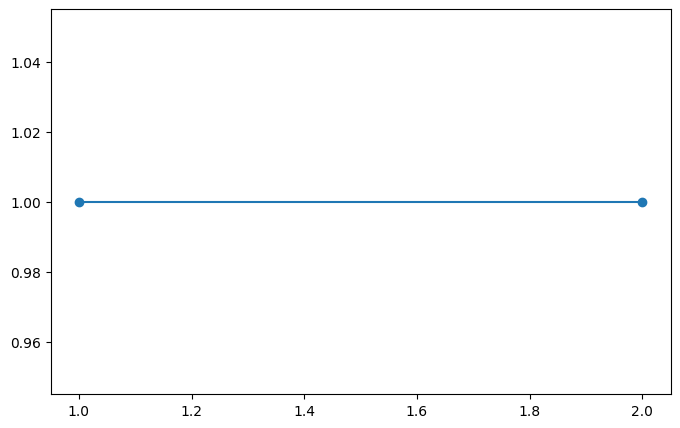

In [166]:
# Extract training top-1 accuracy from history.
# Adjust the key based on your metric name (e.g., "factorized_top_k/top_1_categorical_accuracy")
train_top1 = history.history['factorized_top_k/top_1_categorical_accuracy']

# Extract test top-1 accuracy from the custom callback
test_top1 = [metrics['factorized_top_k/top_1_categorical_accuracy'] for metrics in test_evaluator.test_metrics]

# Define the number of epochs (assuming both lists have the same length)
epochs = range(1, len(train_top1) + 1)

# Plot training and test metrics
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_top1, marker='o', label='Train Top-1 Accuracy')
plt.plot(epochs, test_top1, marker='o', label='Test Top-1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.title('Train vs Test Top-1 Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [167]:
# Set up the retrieval index
index = tfrs.layers.factorized_top_k.BruteForce(model.boardgame_model)
index.index_from_dataset(
    candidate_dataset.map(lambda x: (x["game_id"], model.boardgame_model(x["features"])))
)


In [168]:
feature_names = ['game_name', 'rank', 'average', 'usersrated', 'playingtime','averageweight']
df_input = df_merged[feature_names]
df_input.tail()

,game_name,rank,average,usersrated,playingtime,averageweight
27920,Bingo,27921,3.03029,2797,60.0,1.0381
27921,War,27922,2.39123,1755,30.0,1.0064
27922,Candy Land,27923,3.20277,5082,30.0,1.1370
27923,Chutes and Ladders,27924,2.91774,4904,30.0,1.0397
27924,Tic-Tac-Toe,27925,2.75726,4099,1.0,1.2810


In [169]:
user_input = 'Bingo'
user_input_game_id = df_merged.loc[df_merged['game_name'] == user_input, 'game_id'].values
user_input_game_id

array([7316], dtype=int64)

In [170]:

query_features = np.array(df_input[df_input['game_name'] == user_input].iloc[:, 1:].values.tolist())
query_features

array([[2.79210e+04, 3.03029e+00, 2.79700e+03, 6.00000e+01, 1.03810e+00]])

In [147]:
scores, recommended_game_ids = index(query_features, k=10)
recommended_game_ids.numpy()

TypeError: 'int' object is not callable

In [ ]:
filtered_recommendations_ids = recommended_game_ids[recommended_game_ids != user_input_game_id]

In [ ]:
game_names = df_merged.loc[
    df_merged["game_id"].isin(filtered_recommendations_ids.numpy()),
    "game_name"
]
game_names

9                          Spirit Island
29                                  Root
38         Viticulture Essential Edition
44                             Crokinole
47                           Puerto Rico
54                            Blood Rage
56                              Agricola
83     Five Tribes: The Djinns of Naqala
175                            Stone Age
Name: game_name, dtype: object

In [ ]:
print("Recommended Boardgames:", filtered_recommendations_ids.numpy())

Recommended Boardgames: [237182 170216  31260 157354  34635 162886 183394    521   3076]


Top candidate IDs: [ 41658 154892 161926  99219  15474 220738    533 341164  10681 169341]
Top scores: [0.9999602  0.9999362  0.99992025 0.9999031  0.9998442  0.99981064
 0.99981004 0.9997422  0.9997411  0.99970573]


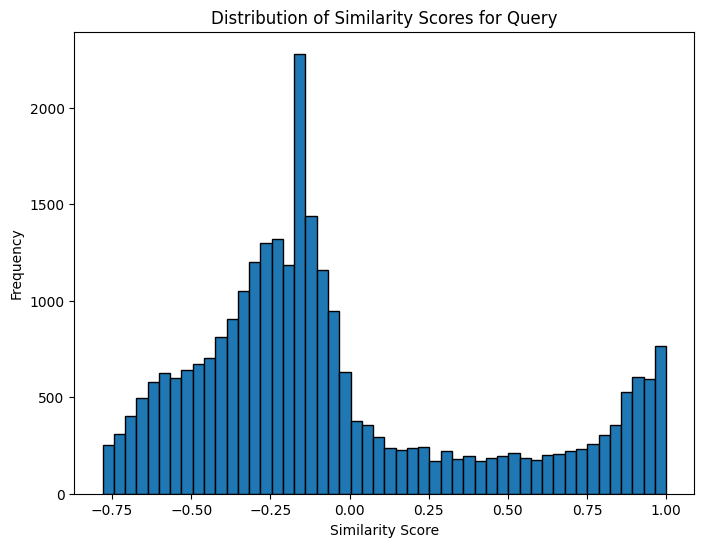

In [171]:
# Assume df_features and df_ids are your complete candidate features and ids.
# Create a raw candidate dataset (unbatched).
raw_candidate_ds = tf.data.Dataset.from_tensor_slices({
    "features": df_features.to_numpy().astype("float32"),
    "game_id": df_game_ids.to_numpy().astype("int32")
}).map(lambda x: (x["features"], x["game_id"]))

# Batch the candidate dataset uniformly.
candidate_embeddings_ds = raw_candidate_ds.batch(1024, drop_remainder=True).map(
    lambda features_batch, id_batch: (model.boardgame_model(features_batch), id_batch)
)

# Collect all candidate embeddings into one tensor.
all_candidate_embeddings = []
all_candidate_ids = []
for embeddings, ids in candidate_embeddings_ds:
    all_candidate_embeddings.append(embeddings)
    all_candidate_ids.append(ids)

combined_candidate_embeddings = tf.concat(all_candidate_embeddings, axis=0)
combined_candidate_ids = tf.concat(all_candidate_ids, axis=0)

# Compute the query embedding (assume query_features has shape (1, 5)).
query_embedding = model.boardgame_model(query_features)  # shape: (1, embedding_dim)

# Compute similarity scores (dot product) between the query and all candidate embeddings.
# This produces a (1, num_candidates) tensor.
scores = tf.matmul(query_embedding, combined_candidate_embeddings, transpose_b=True)
scores = tf.squeeze(scores)  # shape: (num_candidates,)

# Optionally, sort to get top-k recommendations:
top_k = tf.math.top_k(scores, k=10)
top_candidate_ids = tf.gather(combined_candidate_ids, top_k.indices)
print("Top candidate IDs:", top_candidate_ids.numpy())
print("Top scores:", top_k.values.numpy())

# Plot the distribution of similarity scores.
plt.figure(figsize=(8, 6))
plt.hist(scores.numpy(), bins=50, edgecolor="k")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores for Query")
plt.show()
